# LangGraph HITL (Human-in-the-Loop) 활용

---

## 환경 설정 및 준비

`(1) Env 환경변수`

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

`(2) 기본 라이브러리`

In [2]:
import os
from glob import glob
from pprint import pprint
import json
from datetime import datetime

---

## **Human-in-the-Loop (사용자 개입)**

- **HITL 핵심 개념**

    - **HITL**는 AI 시스템에 인간의 판단과 전문성을 통합하는 패턴
    - **Breakpoints**로 특정 단계에서 실행 중지 가능
    - **Checkpointer**를 통해 그래프 상태를 저장하고 재개 가능

- **HITL 활용**

    - 사용자의 **입력**이나 **승인**을 기다리는 패턴으로 작동
    - 시스템 결정에 대한 **인간의 통제**와 **검증** 보장

### LangGraph의 **두 가지 Breakpoint** 설정 방법


1. **정적 브레이크포인트 (Static Breakpoints)**

- 특정 노드 전후에 자동으로 실행을 중단하는 방식

- **컴파일 시점 설정:**

    ```python
    # 컴파일 시 브레이크포인트 설정
    graph = builder.compile(
        checkpointer=checkpointer,
        interrupt_before=["node_a"],  # 노드 실행 전 중단
        interrupt_after=["node_b", "node_c"],  # 노드 실행 후 중단
    )
    ```

- **런타임 설정:**

    ```python
    # 실행 시 브레이크포인트 설정 (서브그래프에는 미지원)
    graph.invoke(
        inputs,
        interrupt_before=["node_a"],
        interrupt_after=["node_b", "node_c"],
        config={"configurable": {"thread_id": "some_thread"}},
    )
    ```

2. **동적 브레이크포인트 (Dynamic Breakpoints) - interrupt 함수**

- 노드 내부에서 `interrupt()` 함수를 호출하여 조건부로 실행을 중단

    ```python
    from langgraph.types import interrupt, Command

    def human_review_node(state: State) -> State:
        # 조건부로 사용자 개입 요청
        if state.get("requires_review"):
            user_input = interrupt({
                "question": "이 작업을 승인하시겠습니까?",
                "context": state["data"]
            })
            return {"approval": user_input}
        return state
    ```

- **Breakpoint 비교표**

    | 특성 | 정적 브레이크포인트 | 동적 브레이크포인트 (interrupt) |
    |-----|------------------|---------------------------|
    | **설정 방법** | `compile()` 또는 `invoke()` 시 | 노드 내부에서 `interrupt()` 호출 |
    | **중단 시점** | 노드 전/후 자동 | 조건부/필요시 |
    | **유연성** | 낮음 (미리 정의) | 높음 (동적 결정) |
    | **사용 사례** | 디버깅, 정해진 검토 지점 | 조건부 승인, 동적 사용자 입력 |
    | **데이터 전달** | 상태 전체 접근 | 커스텀 페이로드 전달 가능 |


### (1) 정적 브레이크포인트 예제

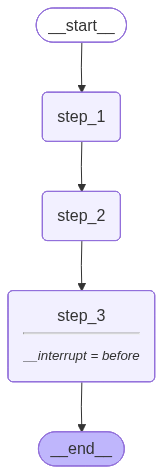

In [3]:
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

class SimpleState(TypedDict):
    input: str

def step_1(state):
    print("---Step 1 실행---")
    return {"input": state.get("input", "") + " (1)"}

def step_2(state):
    print("---Step 2 실행---")
    return {"input": state.get("input", "") + " (2)"}

def step_3(state):
    print("---Step 3 실행---")
    return {"input": state.get("input", "") + " (3)"}

# 그래프 구성
builder = StateGraph(SimpleState)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)

builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

# 체크포인터 설정
checkpointer = InMemorySaver()

# 컴파일 시 정적 브레이크포인트 설정
graph = builder.compile(
    checkpointer=checkpointer,
    interrupt_before=["step_3"]  # step_3 실행 전 중단
)

# 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

In [4]:
# 실행
initial_input = {"input": "hello world"}
thread = {"configurable": {"thread_id": "1"}}

# 첫 번째 실행 - 브레이크포인트에서 중단
print("=== 첫 번째 실행 ===")
for event in graph.stream(initial_input, thread, stream_mode="values"):
    print(event)

=== 첫 번째 실행 ===
{'input': 'hello world'}
---Step 1 실행---
{'input': 'hello world (1)'}
---Step 2 실행---
{'input': 'hello world (1) (2)'}


In [5]:
# 상태 확인
state = graph.get_state(thread)
print(f"\n현재 상태: {state.values}")
print(f"다음 노드: {state.next}")


현재 상태: {'input': 'hello world (1) (2)'}
다음 노드: ('step_3',)


In [6]:
# 재개 - None을 입력으로 전달
print("\n=== 실행 재개 ===")
for event in graph.stream(None, thread, stream_mode="values"):
    print(event)


=== 실행 재개 ===
{'input': 'hello world (1) (2)'}
---Step 3 실행---
{'input': 'hello world (1) (2) (3)'}


### (3) 동적 브레이크포인트 예제 - interrupt 함수 사용

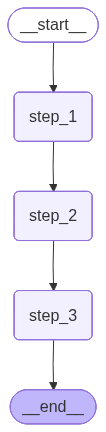

In [7]:
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.types import interrupt, Command
from IPython.display import Image, display
import uuid

class SimpleState(TypedDict):
    input: str
    user_decision: str

def step_1(state):
    print("---Step 1 실행---")
    return {"input": state.get("input", "") + " (1)"}

def step_2(state):
    print("---Step 2 실행---")
    return {"input": state.get("input", "") + " (2)"}

def step_3_with_interrupt(state):
    print("---Step 3 시작 (동적 브레이크포인트)---")
    
    # 동적 브레이크포인트: interrupt() 함수 사용
    user_decision = interrupt({
        "message": "Step 3를 실행하시겠습니까?",
        "current_state": state.get("input", ""),
        "options": ["proceed", "skip", "modify"]
    })
    
    if user_decision == "proceed":
        print("---Step 3 실행 (사용자 승인됨)---")
        return {"input": state.get("input", "") + " (3)", "user_decision": user_decision}
    elif user_decision == "skip":
        print("---Step 3 건너뜀 (사용자 요청)---")
        return {"input": state.get("input", "") + " (skipped)", "user_decision": user_decision}
    else:  # modify
        print("---Step 3 수정됨 (사용자 요청)---")
        return {"input": state.get("input", "") + " (modified)", "user_decision": user_decision}

# 그래프 구성
builder = StateGraph(SimpleState)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3_with_interrupt)

builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

# 체크포인터 설정 (interrupt 사용을 위해 필수)
checkpointer = InMemorySaver()

# 컴파일 (동적 브레이크포인트는 코드 내에서 interrupt() 함수로 설정)
graph = builder.compile(checkpointer=checkpointer)

# 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
# 설정
initial_input = {"input": "hello world"}
thread_config = {"configurable": {"thread_id": str(uuid.uuid4())}}

# 첫 번째 실행 - interrupt에서 중단
result = graph.invoke(initial_input, config=thread_config)

---Step 1 실행---
---Step 2 실행---
---Step 3 시작 (동적 브레이크포인트)---


In [9]:
# interrupt 정보 확인
print(f"Interrupt 내용: {result.get('__interrupt__')}")

Interrupt 내용: [Interrupt(value={'message': 'Step 3를 실행하시겠습니까?', 'current_state': 'hello world (1) (2)', 'options': ['proceed', 'skip', 'modify']}, id='8c4bf2d8c274ad367516db7c75491275')]


In [10]:
# 현재 상태 확인
state = graph.get_state(thread_config)
print(f"\n현재 상태: {state.values}")
print(f"다음 노드: {state.next}")
print(f"Interrupt 정보: {state.interrupts}")


현재 상태: {'input': 'hello world (1) (2)'}
다음 노드: ('step_3',)
Interrupt 정보: (Interrupt(value={'message': 'Step 3를 실행하시겠습니까?', 'current_state': 'hello world (1) (2)', 'options': ['proceed', 'skip', 'modify']}, id='8c4bf2d8c274ad367516db7c75491275'),)


In [11]:
# Command를 사용하여 실행 재개

# "proceed" 옵션으로 재개
final_result = graph.invoke(Command(resume="proceed"), config=thread_config)

---Step 3 시작 (동적 브레이크포인트)---
---Step 3 실행 (사용자 승인됨)---


In [12]:
print(f"최종 결과: {final_result}")

최종 결과: {'input': 'hello world (1) (2) (3)', 'user_decision': 'proceed'}


In [13]:
# 새로운 스레드로 다른 옵션 테스트
thread_config_2 = {"configurable": {"thread_id": str(uuid.uuid4())}}

result_2 = graph.invoke(initial_input, config=thread_config_2)

---Step 1 실행---
---Step 2 실행---
---Step 3 시작 (동적 브레이크포인트)---


In [14]:
# 현재 상태 확인
state = graph.get_state(thread_config_2)
print(f"\n현재 상태: {state.values}")
print(f"다음 노드: {state.next}")
print(f"Interrupt 정보: {state.interrupts}")


현재 상태: {'input': 'hello world (1) (2)'}
다음 노드: ('step_3',)
Interrupt 정보: (Interrupt(value={'message': 'Step 3를 실행하시겠습니까?', 'current_state': 'hello world (1) (2)', 'options': ['proceed', 'skip', 'modify']}, id='12fce7d181d067df9c124004b85f52ef'),)


In [15]:
# 사용자가 Skip 선택으로 재개
final_result_2 = graph.invoke(Command(resume="skip"), config=thread_config_2)
print(f"Skip 결과: {final_result_2}")

---Step 3 시작 (동적 브레이크포인트)---
---Step 3 건너뜀 (사용자 요청)---
Skip 결과: {'input': 'hello world (1) (2) (skipped)', 'user_decision': 'skip'}


### 핵심 포인트 정리

1. **Checkpointer는 필수**
   - HITL 기능을 사용하려면 반드시 checkpointer 설정 필요
   - `InMemorySaver()` (개발), `SqliteSaver()` (프로덕션) 등 선택

2. **Breakpoint 선택 가이드**
   - **정적**: 디버깅, 고정된 검토 지점
   - **동적(interrupt)**: 조건부 개입, 사용자 입력 필요

3. **상태 관리**
   - `graph.get_state(config)`: 현재 상태 확인
   - `Command(resume=value)`: 실행 재개 및 값 전달
   - `Command(goto=node)`: 특정 노드로 이동

---

### **웹 검색 기반 리서치 시스템 구현**

- **주제 분석**: 사용자가 제공한 주제를 분석하여 검색 키워드 생성 (사용자가 직접 검토 및 수정 가능)
- **웹 검색**: 다양한 소스에서 관련 정보 수집
- **보고서 작성**: AI가 종합적인 리서치 보고서 초안 생성
- **사용자 검토**: 사용자가 보고서 내용을 검토하고 수정 요청
- **최종 완성**: 피드백을 반영한 최종 보고서 생성

### (1) 상태 정의 및 도구 설정

In [16]:
from typing import List, Dict, Annotated, Optional
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.types import interrupt, Command, Send
from langchain_openai import ChatOpenAI
from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage, AIMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate
from IPython.display import Image, display
import operator

# ========================================
# State 정의 (Reducer 포함)
# ========================================

class ResearchState(MessagesState):
    topic: str                  # 연구 주제
    keywords: List[str]         # 검색 키워드

    ready_for_search: bool      # 검색 준비 완료 여부
    search_results: Annotated[List[Dict], operator.add]  # Reducer로 Send 결과 자동 병합
    report: str                 # 최종 보고서

    feedback: str               # 피드백

# ========================================
# LLM, 도구 설정
# ========================================

llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0.7)
search_tool = TavilySearch(max_results=3)

### (2) 그래프 노드 정의 및 연결

- **주제 분석**: 사용자가 제공한 주제를 분석하여 검색 키워드 생성

In [17]:
# pydantic 모델 (구조화된 출력용)
class Keywords(BaseModel):
    """키워드 생성 결과"""
    keywords: List[str] = Field(description="생성된 키워드 목록")
    confidence: float = Field(description="키워드 신뢰도")


def generate_keywords(state: ResearchState) -> ResearchState:
    """Pydantic으로 구조화된 키워드 생성"""
    prompt = ChatPromptTemplate.from_messages([
        ("system", "전문 리서치 분석가로서 효과적인 검색 키워드를 생성하세요."),
        ("human", "주제: {topic}\n3-7개 키워드와 신뢰도(0-1)를 생성하세요.")
    ])
    # 구조화된 출력
    chain = prompt | llm.with_structured_output(Keywords)
    result = chain.invoke({"topic": state["topic"]})
    
    if result.keywords is None or len(result.keywords) == 0:
        return {
            "keywords": [],
            "messages": [AIMessage("키워드 생성에 실패했습니다.")]
        } # type: ignore
    
    return {
        "keywords": result.keywords,
        "messages": [AIMessage(f"키워드 {len(result.keywords)}개 생성 (신뢰도: {result.confidence:.0%})")]
    } # type: ignore

def review_keywords(state: ResearchState) -> ResearchState:
    """Human-in-the-loop: 키워드 검토"""
    keywords_list = "\n".join([f"{i+1}. {k}" for i, k in enumerate(state["keywords"])])

    # interrupt 사용자 입력 대기 (HITL) -> 사용자에게 요청 (사용자가 입력한 내용은 user_input에 저장)
    user_input = interrupt({
        "keywords": state["keywords"],
        "question": f"키워드 검토:\n{keywords_list}\n\n옵션:\n- '승인': 현재 키워드 사용\n- '재생성': 새 키워드 생성\n- '수정: 키워드1,키워드2,...': 직접 수정"
    })

    # 사용자가 입력한 피드백 저장
    return {"feedback": user_input}

def process_keyword_feedback(state: ResearchState) -> ResearchState:
    """키워드 피드백 처리 - 키워드 직접 수정"""
    feedback = state.get("feedback", "").strip()
    
    if not feedback or "승인" in feedback.lower():
        # 승인된 경우
        return {
            "keywords": state["keywords"], 
            "messages": [AIMessage("키워드가 승인되었습니다.")]
        }  # type: ignore

    elif "수정:" in feedback:
        # 직접 수정된 키워드 추출
        try:
            new_keywords_str = feedback.split("수정:", 1)[1].strip()
            new_keywords = [kw.strip() for kw in new_keywords_str.split(",") if kw.strip()]
            return {
                "keywords": new_keywords,
                "messages": [AIMessage(f"키워드가 수정되었습니다: {', '.join(new_keywords)}")]
            }  # type: ignore
        except:
            return {
                "keywords": [],
                "messages": [AIMessage("키워드 형식이 올바르지 않습니다. 재생성합니다.")]
            }  # type: ignore

    else:
        # 재생성 또는 기타 경우
        return {
            "keywords": [],
            "messages": [AIMessage("키워드를 재생성합니다.")]
        }  # type: ignore

`(1) 주제 분석 테스트를 위한 워크플로우 정의`

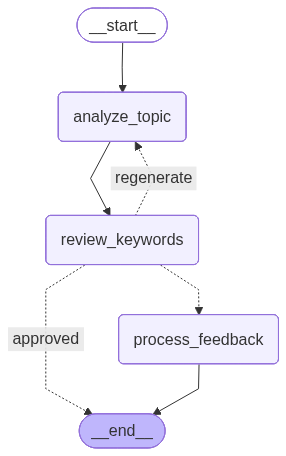

In [18]:
# ===== 워크플로우 그래프 구성 =====
def should_continue_after_review(state: ResearchState) -> str:
    """검토 후 다음 단계 결정"""
    feedback = state.get("feedback", "").strip().lower()

    # 피드백 유형에 따른 다음 단계 결정
    if not feedback or "승인" in feedback:
        return "approved"    # 승인된 경우

    elif "수정:" in feedback:
        return "process_feedback"    # 직접 수정된 키워드 처리

    else:
        return "regenerate"  # 재생성

# StateGraph 생성
workflow = StateGraph(ResearchState)

# 노드 추가
workflow.add_node("analyze_topic", generate_keywords)
workflow.add_node("review_keywords", review_keywords)
workflow.add_node("process_feedback", process_keyword_feedback)

# 엣지 연결
workflow.add_edge(START, "analyze_topic")
workflow.add_edge("analyze_topic", "review_keywords")

# 조건부 엣지
workflow.add_conditional_edges(
    "review_keywords",
    should_continue_after_review,
    {
        "process_feedback": "process_feedback",
        "regenerate": "analyze_topic",  # 재생성시 다시 키워드 생성으로
        "approved": END
    }
)

# 피드백 처리 후 종료
workflow.add_edge("process_feedback", END)

# 그래프 컴파일
graph = workflow.compile(checkpointer=InMemorySaver())

# 상태 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

`(2) 워크플로우 시작`

- **interrupt**까지 실행

In [19]:
# 초기 상태 설정
initial_state = {
    "topic": "인공지능 기술 발전"
}

# 스레드 설정
config = {"configurable": {"thread_id": f"test_thread_1"}}


# 워크플로우 실행
# 첫 번째 실행 - 중단점에서 실행을 멈춤
for event in graph.stream(initial_state, config=config):
    print(f"Event: {event}")

Event: {'analyze_topic': {'keywords': ['인공지능', '머신러닝', '딥러닝', '자연어 처리', '컴퓨터 비전', '강화 학습', 'AI 윤리'], 'messages': [AIMessage(content='키워드 7개 생성 (신뢰도: 95%)', additional_kwargs={}, response_metadata={}, id='de45f6ec-0e43-444d-bc48-8210fc2b97a7')]}}
Event: {'__interrupt__': (Interrupt(value={'keywords': ['인공지능', '머신러닝', '딥러닝', '자연어 처리', '컴퓨터 비전', '강화 학습', 'AI 윤리'], 'question': "키워드 검토:\n1. 인공지능\n2. 머신러닝\n3. 딥러닝\n4. 자연어 처리\n5. 컴퓨터 비전\n6. 강화 학습\n7. AI 윤리\n\n옵션:\n- '승인': 현재 키워드 사용\n- '재생성': 새 키워드 생성\n- '수정: 키워드1,키워드2,...': 직접 수정"}, id='521453fb7609612c3bf319aa2f36e27f'),)}


`(3) 현재 상태 확인`

- **get_state** 함수로 현재 상태 확인 가능


In [20]:
# 현재 상태 - 그래프 체크포인트 확인
current_state = graph.get_state(config)

print(f"\n현재 상태: {current_state.values}")
print(f"대기 중인 interrupt: {current_state.tasks}")


현재 상태: {'messages': [AIMessage(content='키워드 7개 생성 (신뢰도: 95%)', additional_kwargs={}, response_metadata={}, id='de45f6ec-0e43-444d-bc48-8210fc2b97a7')], 'topic': '인공지능 기술 발전', 'keywords': ['인공지능', '머신러닝', '딥러닝', '자연어 처리', '컴퓨터 비전', '강화 학습', 'AI 윤리'], 'search_results': []}
대기 중인 interrupt: (PregelTask(id='c52b674b-3ea1-5ee5-e6d3-722022f9f89a', name='review_keywords', path=('__pregel_pull', 'review_keywords'), error=None, interrupts=(Interrupt(value={'keywords': ['인공지능', '머신러닝', '딥러닝', '자연어 처리', '컴퓨터 비전', '강화 학습', 'AI 윤리'], 'question': "키워드 검토:\n1. 인공지능\n2. 머신러닝\n3. 딥러닝\n4. 자연어 처리\n5. 컴퓨터 비전\n6. 강화 학습\n7. AI 윤리\n\n옵션:\n- '승인': 현재 키워드 사용\n- '재생성': 새 키워드 생성\n- '수정: 키워드1,키워드2,...': 직접 수정"}, id='521453fb7609612c3bf319aa2f36e27f'),), state=None, result=None),)


In [21]:
# 다음에 실행될 노드를 확인 
current_state.next

('review_keywords',)

In [22]:
# 대기 중인 interrupt 확인
task = current_state.tasks[0]
print(task.id)
print(task.name)
pprint(task.interrupts[0].value)

c52b674b-3ea1-5ee5-e6d3-722022f9f89a
review_keywords
{'keywords': ['인공지능', '머신러닝', '딥러닝', '자연어 처리', '컴퓨터 비전', '강화 학습', 'AI 윤리'],
 'question': '키워드 검토:\n'
             '1. 인공지능\n'
             '2. 머신러닝\n'
             '3. 딥러닝\n'
             '4. 자연어 처리\n'
             '5. 컴퓨터 비전\n'
             '6. 강화 학습\n'
             '7. AI 윤리\n'
             '\n'
             '옵션:\n'
             "- '승인': 현재 키워드 사용\n"
             "- '재생성': 새 키워드 생성\n"
             "- '수정: 키워드1,키워드2,...': 직접 수정"}


`(4) 사용자 개입 (HITL): 거부`

- 사용자가 승인을 해주지 않는 경우, 피드백을 통해 다시 생성
- **Command** 함수로 사용자 피드백 전달

In [23]:
from langgraph.types import Command

# 사용자 피드백 제공 (거부: 재생성 요청)
human_feedback = "재생성"

print(f"config: ", config)

# 사용자 입력으로 그래프 재개 (Command 사용)
for event in graph.stream(Command(resume=human_feedback), config=config):
    print(f"Event: {event}")

config:  {'configurable': {'thread_id': 'test_thread_1'}}
Event: {'review_keywords': {'feedback': '재생성'}}
Event: {'analyze_topic': {'keywords': ['인공지능', '머신러닝', '딥러닝', '자연어 처리', '컴퓨터 비전', '강화학습', 'AI 윤리'], 'messages': [AIMessage(content='키워드 7개 생성 (신뢰도: 95%)', additional_kwargs={}, response_metadata={}, id='cabea217-06a4-4334-a461-8bd213026c6e')]}}
Event: {'__interrupt__': (Interrupt(value={'keywords': ['인공지능', '머신러닝', '딥러닝', '자연어 처리', '컴퓨터 비전', '강화학습', 'AI 윤리'], 'question': "키워드 검토:\n1. 인공지능\n2. 머신러닝\n3. 딥러닝\n4. 자연어 처리\n5. 컴퓨터 비전\n6. 강화학습\n7. AI 윤리\n\n옵션:\n- '승인': 현재 키워드 사용\n- '재생성': 새 키워드 생성\n- '수정: 키워드1,키워드2,...': 직접 수정"}, id='c2809c22a86d8a5fbc377fd3d541cc11'),)}


In [24]:
# 현재 상태 - 그래프 체크포인트 확인
current_state = graph.get_state(config)

print(f"\n현재 상태: {current_state.values}")
print(f"대기 중인 interrupt: {current_state.tasks}")


현재 상태: {'messages': [AIMessage(content='키워드 7개 생성 (신뢰도: 95%)', additional_kwargs={}, response_metadata={}, id='de45f6ec-0e43-444d-bc48-8210fc2b97a7'), AIMessage(content='키워드 7개 생성 (신뢰도: 95%)', additional_kwargs={}, response_metadata={}, id='cabea217-06a4-4334-a461-8bd213026c6e')], 'topic': '인공지능 기술 발전', 'keywords': ['인공지능', '머신러닝', '딥러닝', '자연어 처리', '컴퓨터 비전', '강화학습', 'AI 윤리'], 'search_results': [], 'feedback': '재생성'}
대기 중인 interrupt: (PregelTask(id='be3e3976-9d5b-4494-78fa-633360e5811a', name='review_keywords', path=('__pregel_pull', 'review_keywords'), error=None, interrupts=(Interrupt(value={'keywords': ['인공지능', '머신러닝', '딥러닝', '자연어 처리', '컴퓨터 비전', '강화학습', 'AI 윤리'], 'question': "키워드 검토:\n1. 인공지능\n2. 머신러닝\n3. 딥러닝\n4. 자연어 처리\n5. 컴퓨터 비전\n6. 강화학습\n7. AI 윤리\n\n옵션:\n- '승인': 현재 키워드 사용\n- '재생성': 새 키워드 생성\n- '수정: 키워드1,키워드2,...': 직접 수정"}, id='c2809c22a86d8a5fbc377fd3d541cc11'),), state=None, result=None),)


In [25]:
# 다음에 실행될 노드를 확인 
current_state.next

('review_keywords',)

In [26]:
# 대기 중인 interrupt 확인
task = current_state.tasks[0]
print(task.id)
print(task.name)
pprint(task.interrupts[0].value)

be3e3976-9d5b-4494-78fa-633360e5811a
review_keywords
{'keywords': ['인공지능', '머신러닝', '딥러닝', '자연어 처리', '컴퓨터 비전', '강화학습', 'AI 윤리'],
 'question': '키워드 검토:\n'
             '1. 인공지능\n'
             '2. 머신러닝\n'
             '3. 딥러닝\n'
             '4. 자연어 처리\n'
             '5. 컴퓨터 비전\n'
             '6. 강화학습\n'
             '7. AI 윤리\n'
             '\n'
             '옵션:\n'
             "- '승인': 현재 키워드 사용\n"
             "- '재생성': 새 키워드 생성\n"
             "- '수정: 키워드1,키워드2,...': 직접 수정"}


`(5) 사용자 개입 (HITL): 수정`

- 사용자가 승인을 해주지 않는 경우, 피드백을 통해 다시 생성
- **Command** 함수로 사용자 피드백 전달

In [27]:
from langgraph.types import Command

# 사용자 피드백 제공 (거부: 직접 키워드 수정)
human_feedback = "수정: 생성형 AI, LLM 발전"

print(f"config: ", config)

# 사용자 입력으로 그래프 재개 (Command 사용)
for event in graph.stream(Command(resume=human_feedback), config=config):
    print(f"Event: {event}")

config:  {'configurable': {'thread_id': 'test_thread_1'}}
Event: {'review_keywords': {'feedback': '수정: 생성형 AI, LLM 발전'}}
Event: {'process_feedback': {'keywords': ['생성형 AI', 'LLM 발전'], 'messages': [AIMessage(content='키워드가 수정되었습니다: 생성형 AI, LLM 발전', additional_kwargs={}, response_metadata={}, id='ab7697f2-feaa-42e0-b447-7f34baaf9b4e')]}}


In [28]:
# 현재 상태 - 그래프 체크포인트 확인
current_state = graph.get_state(config)

print(f"\n현재 상태: {current_state.values}")
print(f"대기 중인 interrupt: {current_state.tasks}")


현재 상태: {'messages': [AIMessage(content='키워드 7개 생성 (신뢰도: 95%)', additional_kwargs={}, response_metadata={}, id='de45f6ec-0e43-444d-bc48-8210fc2b97a7'), AIMessage(content='키워드 7개 생성 (신뢰도: 95%)', additional_kwargs={}, response_metadata={}, id='cabea217-06a4-4334-a461-8bd213026c6e'), AIMessage(content='키워드가 수정되었습니다: 생성형 AI, LLM 발전', additional_kwargs={}, response_metadata={}, id='ab7697f2-feaa-42e0-b447-7f34baaf9b4e')], 'topic': '인공지능 기술 발전', 'keywords': ['생성형 AI', 'LLM 발전'], 'search_results': [], 'feedback': '수정: 생성형 AI, LLM 발전'}
대기 중인 interrupt: ()


In [29]:
# 다음에 실행될 노드를 확인 
current_state.next

()

`(5) 사용자 개입 (HITL): 승인`

- 사용자가 '승인'을 해서 최종 답변을 생성하고 종료

In [30]:
# 초기 상태 설정
initial_state = {
    "topic": "기후변화 위기"
}

# 스레드 설정
config = {"configurable": {"thread_id": f"test_thread_2"}}


# 워크플로우 실행
# 첫 번째 실행 - 중단점에서 실행을 멈춤
for event in graph.stream(initial_state, config=config):
    print(f"Event: {event}")

Event: {'analyze_topic': {'keywords': ['기후변화', '지구온난화', '탄소배출', '재생에너지', '기후위기', '온실가스', '환경보호'], 'messages': [AIMessage(content='키워드 7개 생성 (신뢰도: 95%)', additional_kwargs={}, response_metadata={}, id='db896881-49b4-4fea-9c0d-be2e27d40468')]}}
Event: {'__interrupt__': (Interrupt(value={'keywords': ['기후변화', '지구온난화', '탄소배출', '재생에너지', '기후위기', '온실가스', '환경보호'], 'question': "키워드 검토:\n1. 기후변화\n2. 지구온난화\n3. 탄소배출\n4. 재생에너지\n5. 기후위기\n6. 온실가스\n7. 환경보호\n\n옵션:\n- '승인': 현재 키워드 사용\n- '재생성': 새 키워드 생성\n- '수정: 키워드1,키워드2,...': 직접 수정"}, id='49775210becc76a5a8d3f0b991ebdf54'),)}


In [31]:
# 현재 상태 - 그래프 체크포인트 확인
current_state = graph.get_state(config)

print(f"\n현재 상태: {current_state.values}")
print(f"대기 중인 interrupt: {current_state.tasks}")


현재 상태: {'messages': [AIMessage(content='키워드 7개 생성 (신뢰도: 95%)', additional_kwargs={}, response_metadata={}, id='db896881-49b4-4fea-9c0d-be2e27d40468')], 'topic': '기후변화 위기', 'keywords': ['기후변화', '지구온난화', '탄소배출', '재생에너지', '기후위기', '온실가스', '환경보호'], 'search_results': []}
대기 중인 interrupt: (PregelTask(id='4fba22ad-417e-e5b8-e7be-f4e16e3a399e', name='review_keywords', path=('__pregel_pull', 'review_keywords'), error=None, interrupts=(Interrupt(value={'keywords': ['기후변화', '지구온난화', '탄소배출', '재생에너지', '기후위기', '온실가스', '환경보호'], 'question': "키워드 검토:\n1. 기후변화\n2. 지구온난화\n3. 탄소배출\n4. 재생에너지\n5. 기후위기\n6. 온실가스\n7. 환경보호\n\n옵션:\n- '승인': 현재 키워드 사용\n- '재생성': 새 키워드 생성\n- '수정: 키워드1,키워드2,...': 직접 수정"}, id='49775210becc76a5a8d3f0b991ebdf54'),), state=None, result=None),)


In [32]:
# 피드백 요청 메시지 출력
print(current_state.tasks[0].interrupts[0].value.get("question"))

키워드 검토:
1. 기후변화
2. 지구온난화
3. 탄소배출
4. 재생에너지
5. 기후위기
6. 온실가스
7. 환경보호

옵션:
- '승인': 현재 키워드 사용
- '재생성': 새 키워드 생성
- '수정: 키워드1,키워드2,...': 직접 수정


In [33]:
from langgraph.types import Command

# 사용자 피드백 제공 (승인 문자열을 사용)
human_feedback = "승인"

# 사용자 입력으로 그래프 재개
for event in graph.stream(Command(resume=human_feedback), config=config):
    print(f"Event: {event}")

Event: {'review_keywords': {'feedback': '승인'}}


In [34]:
# 현재 상태 - 그래프 체크포인트 확인
current_state = graph.get_state(config)

print(f"\n현재 상태: {current_state.values}")
print(f"대기 중인 interrupt: {current_state.tasks}")


현재 상태: {'messages': [AIMessage(content='키워드 7개 생성 (신뢰도: 95%)', additional_kwargs={}, response_metadata={}, id='db896881-49b4-4fea-9c0d-be2e27d40468')], 'topic': '기후변화 위기', 'keywords': ['기후변화', '지구온난화', '탄소배출', '재생에너지', '기후위기', '온실가스', '환경보호'], 'search_results': [], 'feedback': '승인'}
대기 중인 interrupt: ()


In [35]:
# 다음 노드 확인
current_state.next

()

In [36]:
# 현재 상태 출력
pprint(current_state.values)

{'feedback': '승인',
 'keywords': ['기후변화', '지구온난화', '탄소배출', '재생에너지', '기후위기', '온실가스', '환경보호'],
 'messages': [AIMessage(content='키워드 7개 생성 (신뢰도: 95%)', additional_kwargs={}, response_metadata={}, id='db896881-49b4-4fea-9c0d-be2e27d40468')],
 'search_results': [],
 'topic': '기후변화 위기'}


- **웹 검색**: 다양한 소스에서 관련 정보 수집

    - 맵-리듀스 패턴으로 병렬 검색 수행
    - `Send` 사용

In [37]:
results = search_tool.invoke("기후변화")
results

{'query': '기후변화',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://ko.wikipedia.org/wiki/%EA%B8%B0%ED%9B%84%EB%B3%80%ED%99%94',
   'title': '기후변화 - 위키백과, 우리 모두의 백과사전',
   'content': '기후변화(氣候變化, climate change)는 지구의 평균 기온이 점진적으로 상승하면서 전지구적 기후 패턴이 급격하게 변화하는 현상이다. 과거에는 지구 온난화(地球溫暖',
   'score': 0.8934678,
   'raw_content': None},
  {'url': 'https://www.gihoo.or.kr/menu.es?mid=a30109000000',
   'title': '기후변화란? - 탄소중립포털',
   'content': '반면 기후는 다년간 관측된 정보를 기반으로 평균기상(Average Weather)을 예측하기에 대기 조성이나 기타 인자들의 변화로 인한 기후변화(즉, 장기적 평균 기상)를 전망해볼 수 있습니다. 오랜 기간(수십 년 또는 그 이상) 동안 지속되면서 기후의 평균 상태나 그 변동 속에서 통계적으로 의미 있는 변동으로 ‘인간 활동에 의한 것’이든 ‘자연적인 변동’이든 시간 경과에 따른 기후의 변화를 포괄함 * **UNFCCC 정의** United Nations Framework Convention on Climate Change 전 지구 대기의 조성을 변화시키는 인간의 활동이 직접적 또는 간접적인 요인으로 일어나고, 장기간에 걸쳐 관측된 자연적인 기후변동성에 추가하여 일어나는 기후의 변화로 정의. 기후위기에 대응하기 위한 방안은 온실가스 감축과 기후위기 적응 2가지로 나눌 수 있습니다. 기후변화를\xa0완화 또는 지연시키기 위하여 대기\xa0중 온실가스 농도가 인간활동에 의해 더 증가되지 않도록 온실가스 배출량을 줄이거나\x

In [38]:
# ===== 검색 노드 =====
def ready_to_search(state: ResearchState) -> ResearchState:
    """검색 준비"""
    return {"ready_for_search": True}

def dispatch_searches(state: ResearchState) -> List[Send]:
    """병렬 검색 디스패치"""
    return [Send("search_one", {"keyword": kw}) for kw in state["keywords"]]

def search_one(state: Dict) -> ResearchState:
    """개별 검색 실행"""
    keyword = state["keyword"]
    try:
        results = search_tool.invoke(keyword)
        data = results.get("results", results) if isinstance(results, dict) else results
        return {
            "search_results": [{
                "keyword": keyword,
                "data": data if isinstance(data, list) else [],
                "success": True
            }]
        }  # type: ignore
    except Exception as e:
        return {
            "search_results": [{
                "keyword": keyword,
                "error": str(e),
                "success": False
            }]
        } # type: ignore


# ===== 보고서 생성  =====
class Report(BaseModel):
    """보고서 모델"""
    summary: str = Field(description="주제 요약")
    findings: List[str] = Field(description="주요 발견사항 리스트 (출처명, 링크 등을 포함)")
    recommendations: List[str] = Field(description="제언 리스트")

def generate_report(state: ResearchState) -> ResearchState:
    """LLM을 사용한 보고서 생성"""

    results = state.get("search_results", [])

    if not results:
        return {"report": f"# {state['topic']}\n\n❌ 검색 결과가 없습니다."}

    prompt = ChatPromptTemplate.from_messages([
        ("system", "당신은 리서치 전문가입니다. 검색 결과를 분석해 간결한 보고서를 작성하세요. 반드시 출처명과 링크를 명확히 표기하고, 신뢰할 수 없는 정보는 포함하지 마세요."),
        ("human", "주제: {topic}\n\n검색 결과:\n{content}")
    ])
    
    try:
        chain = prompt | llm.with_structured_output(Report)
        report = chain.invoke({
            "topic": state["topic"],
            "content": str(results)[:12000]  # 토큰 제한
        })
        
        # 인라인 마크다운 생성
        markdown = f"""# {state["topic"]}

## 📌 요약
{report.summary}

## 🔍 주요 발견사항
{chr(10).join(f"{i}. {finding}" for i, finding in enumerate(report.findings, 1))}

## 💡 제언
{chr(10).join(f"{i}. {rec}" for i, rec in enumerate(report.recommendations, 1))}

---
*생성: {datetime.now().strftime('%Y-%m-%d %H:%M')}*
*검색: {sum(1 for r in state['search_results'] if r.get('success'))}개 성공*"""
        
        return {"report": markdown}
        
    except Exception as e:
        return {"report": f"# {state['topic']}\n\n⚠️ 보고서 생성에 실패했습니다: {str(e)}"}

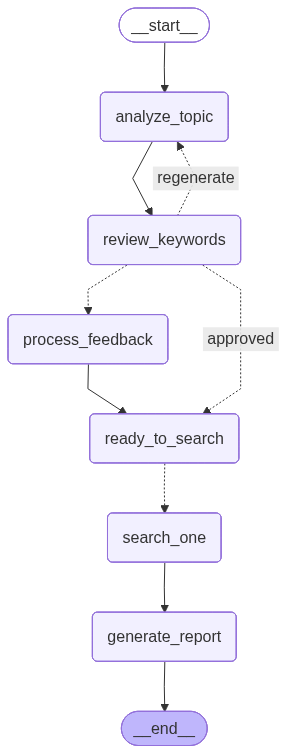

In [39]:
# ===== 워크플로우 구성 =====
# 1. ready_to_search (검색 준비)
# 2. dispatch_searches (병렬 검색 시작)
# 3. search_one (개별 검색 - 병렬)
# 4. generate_report (검색 결과 취합/리듀스) 

workflow = StateGraph(ResearchState)

# 노드 추가
workflow.add_node("analyze_topic", generate_keywords)
workflow.add_node("review_keywords", review_keywords)
workflow.add_node("process_feedback", process_keyword_feedback)

workflow.add_node("ready_to_search", ready_to_search)
workflow.add_node("search_one", search_one)  # Send의 타겟 노드
workflow.add_node("generate_report", generate_report)

# 엣지 연결
workflow.add_edge(START, "analyze_topic")
workflow.add_edge("analyze_topic", "review_keywords")

# 키워드 검토 후 조건부 라우팅
workflow.add_conditional_edges(
    "review_keywords",
    should_continue_after_review,
    {
        "process_feedback": "process_feedback",
        "regenerate": "analyze_topic",
        "approved": "ready_to_search"
    }
)

# 피드백 처리 후 검색
workflow.add_edge("process_feedback", "ready_to_search")

# Send 맵-리듀스 연결
workflow.add_conditional_edges(
    "ready_to_search",
    dispatch_searches,
    ["search_one"]
)
workflow.add_edge("search_one", "generate_report")

# 분석 완료 후 종료
workflow.add_edge("generate_report", END)

# 컴파일
graph = workflow.compile(checkpointer=InMemorySaver())

# 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

In [40]:
# 초기 상태 설정
initial_state = {
    "topic": "2025 한국의 AI 산업"
}

# 스레드 설정
config = {"configurable": {"thread_id": f"test_thread_1"}}


# 워크플로우 실행
# 첫 번째 실행 - 중단점에서 실행을 멈춤
for event in graph.stream(initial_state, config=config):
    print(f"Event: {event}")

Event: {'analyze_topic': {'keywords': ['한국 AI 산업', '2025 AI 전망', '인공지능 기술 발전', 'AI 스타트업 한국', '한국 AI 정책', '머신러닝 한국', 'AI 인재 양성'], 'messages': [AIMessage(content='키워드 7개 생성 (신뢰도: 95%)', additional_kwargs={}, response_metadata={}, id='7c3cc15f-2967-4329-b967-c56cb914657f')]}}
Event: {'__interrupt__': (Interrupt(value={'keywords': ['한국 AI 산업', '2025 AI 전망', '인공지능 기술 발전', 'AI 스타트업 한국', '한국 AI 정책', '머신러닝 한국', 'AI 인재 양성'], 'question': "키워드 검토:\n1. 한국 AI 산업\n2. 2025 AI 전망\n3. 인공지능 기술 발전\n4. AI 스타트업 한국\n5. 한국 AI 정책\n6. 머신러닝 한국\n7. AI 인재 양성\n\n옵션:\n- '승인': 현재 키워드 사용\n- '재생성': 새 키워드 생성\n- '수정: 키워드1,키워드2,...': 직접 수정"}, id='88652d42eb6aecda88a7bf3d36aa00c3'),)}


In [41]:
from langgraph.types import Command

# 사용자 피드백 제공 (승인 문자열을 사용)
human_feedback = "승인"

# 사용자 입력으로 그래프 재개
for event in graph.stream(Command(resume=human_feedback), config=config): 
    print(f"Event: {event}")

Event: {'review_keywords': {'feedback': '승인'}}
Event: {'ready_to_search': {'ready_for_search': True}}
Event: {'search_one': {'search_results': [{'keyword': 'AI 인재 양성', 'data': [{'url': 'https://www.chosun.com/economy/industry-company/2025/06/25/3ZLN63SA2VBKRAGISEV2MHVV2Q/', 'title': "삼성, 매년 청년 AI 인재 2000명 육성… '인공지능 강국' 힘 보탠다", 'content': "# 삼성, 매년 청년 AI 인재 2000명 육성… '인공지능 강국' 힘 보탠다 국내 최대 기업인 삼성이 매년 2000명의 ‘인공지능(AI) 실무 인재’를 대규모로 육성한다. 최근 6년여간 사회 공헌 차원에서 미취업 청년을 매년 수백 명씩 교육해 ‘1만(萬) 소프트웨어 인재’를 키워 낸 삼성이 이제 ‘AI 인재’ 육성에 나서기로 한 것이다. 이로써 지난 2018년 말부터 삼성이 SW 인재 육성을 위해 운영해 온 사회공헌 프로그램 ‘SSAFY’의 누적 수료생은 총 1만명을 돌파(1만125명)했다. 이날 삼성은 그간 SW 중심으로 운영해 왔던 교육을, AI 중심으로 전면 개편하고 프로그램명도 ‘삼성 청년 SW·AI 아카데미(SSAFY 2.0)’로 바꾼다고 밝혔다. 삼성이 ‘독한 교육’을 예고한 만큼, 새 프로그램이 AI 인재 양성에 도움이 될 것이란 기대가 나온다. 교육의 중심이 SW에서 AI로 바뀌면서 이제는 ‘삼성 청년 SW·AI 아카데미(Samsung Software AI academy For Youth)’란 뜻이 됐다.", 'score': 0.7738498, 'raw_content': None}, {'url': 'https://blog.naver.com/moeblog/223990820976?fromRss=true&trackingCode=rss', 'title'

In [42]:
# 마지막 상태 출력
final_state = graph.get_state(config)

final_state.values

{'messages': [AIMessage(content='키워드 7개 생성 (신뢰도: 95%)', additional_kwargs={}, response_metadata={}, id='7c3cc15f-2967-4329-b967-c56cb914657f')],
 'topic': '2025 한국의 AI 산업',
 'keywords': ['한국 AI 산업',
  '2025 AI 전망',
  '인공지능 기술 발전',
  'AI 스타트업 한국',
  '한국 AI 정책',
  '머신러닝 한국',
  'AI 인재 양성'],
 'ready_for_search': True,
 'search_results': [{'keyword': '한국 AI 산업',
   'data': [{'url': 'https://www.investkorea.org/ik-kr/bbs/i-112/detail.do?ntt_sn=491224&clickArea=krmain00019',
     'title': '산업포커스 - 상세보기 | 최신 산업정보 | 인베스트코리아 - Invest Korea',
     'content': '2025년, 한국의 AI 시장 규모는 전년 대비 12.1% 성장한 3조 4,385억원에 이를 것으로 추산되고 있으며, 연평균 성장률 14.3%를 기록하며 2027년 4조 4636',
     'score': 0.7978881,
     'raw_content': None},
    {'url': 'http://www.itdaily.kr/news/articleView.html?idxno=233950',
     'title': "[동향] 2024년 국내 AI 산업 6조 3천억원…구조적 불균형 '경고등'",
     'content': 'AI가 가장 활발히 도입되는 정보통신업(46.0%), 제조업(35.7%), 공공·행정(24.8%) 등에서도 주로 챗봇, 자동화, 영상 분석 등 응용 서비스 중심의 도입이',
     'score': 0.7927375,
     'raw_content': N

In [43]:
# 최종 검색 결과 출력
print(final_state.values.get("report", []))

# 2025 한국의 AI 산업

## 📌 요약
2025년 한국의 AI 산업은 연평균 성장률 14.3%로 빠르게 성장 중이며, 2025년 시장 규모는 약 3조 4,385억원으로 전망된다. 정보통신업, 제조업, 공공·행정 분야에서 AI 도입이 활발하며, 특히 챗봇, 자동화, 영상 분석 등 응용 서비스 중심의 활용이 증가하고 있다. AI 스타트업도 활발히 성장하여 업스테이지, 트웰브랩스, 뤼튼테크놀로지스 등 글로벌 경쟁력을 갖춘 기업들이 두각을 나타내고 있다. 딜로이트 보고서에 따르면 2025년 AI는 휴머노이드 로봇 시대의 본격 개막, 인간과 AI의 상호작용 극대화, AI 거버넌스 강화 등을 핵심 트렌드로 하며, 도시 서비스 혁신과 자동화가 확대될 전망이다. 또한 정부는 AI 신뢰성 확보와 고위험 AI 규제 등 정책적 기반 마련에 적극적으로 나서고 있다.

## 🔍 주요 발견사항
1. 한국의 AI 시장 규모는 2025년 약 3조 4,385억원으로, 연평균 14.3% 성장세를 보인다. (출처: 인베스트코리아 https://www.investkorea.org/ik-kr/bbs/i-112/detail.do?ntt_sn=491224&clickArea=krmain00019)
2. 정보통신업(46%), 제조업(35.7%), 공공·행정(24.8%) 분야에서 AI 도입이 활발하며, 챗봇, 자동화, 영상 분석 등이 주요 응용 서비스로 활용되고 있다. (출처: ITDaily http://www.itdaily.kr/news/articleView.html?idxno=233950)
3. 한국 AI 스타트업은 업스테이지, 트웰브랩스, 뤼튼테크놀로지스 등이 글로벌 시장에서 주목받고 있으며, 대규모 투자 유치와 기술력 확보로 성장 중이다. (출처: 머니투데이 https://www.mt.co.kr/future/2024/12/21/2024121815152811264)
4. 딜로이트는 2025년 AI 핵심 트렌드로 휴머노이드 로봇, 에이전틱 AI, AI 거버넌스, AI 시티 등을 제시하며, 기업과

- **사용자 검토**: 사용자가 보고서 내용을 검토하고 수정 요청

In [44]:
# ===== 보고서 검토 노드 (Human-in-the-loop) =====

def review_report(state: ResearchState) -> ResearchState:
    """Human-in-the-loop: 보고서 검토"""
    
    # 보고서 미리보기 (500자로 제한)
    preview = state["report"][:500] + "..." if len(state["report"]) > 500 else state["report"]
    
    # 사용자 입력 대기
    user_input = interrupt({
        "report_preview": preview,
        "instruction": "보고서를 검토하세요. '승인' 또는 구체적인 수정 요청을 입력하세요:"
    })
    
    return Command(
        goto=END if "승인" in user_input else "revise_report",
        update={"feedback": user_input}
    )  # type: ignore

- **최종 완성**: 피드백을 반영한 최종 보고서 생성

In [45]:
# ===== 보고서 수정 노드 =====
def revise_report(state: ResearchState) -> ResearchState:
    """피드백 처리 및 보고서 수정"""
    
    feedback = state.get("feedback", "").strip()
    
    # 승인인 경우 바로 완료
    if "승인" in feedback.lower() or "approve" in feedback.lower():
        return {
            "messages": [AIMessage("✅ 보고서가 승인되었습니다!")]
        }  # type: ignore

    # 수정 요청 처리
    if feedback:

        # 구조화된 프롬프트 템플릿
        revision_prompt = ChatPromptTemplate.from_messages([
            ("system", """당신은 전문적인 보고서 편집자입니다.
    사용자의 피드백을 반영하여 보고서를 수정하세요.

    
    ## 수정 원칙:
    1. 원본 보고서의 구조와 형식 유지
    2. 사용자 요청사항을 정확히 반영
    3. 전문적이고 명확한 문체 유지
    4. 마크다운 형식 준수"""),
            ("human", """## 현재 보고서:
    {report}

    ## 수정 요청사항:
    {feedback}

    위 요청사항을 반영하여 보고서를 수정해주세요.""")
        ])
        
        try:
            # LLM 체인 실행
            chain = revision_prompt | llm
            response = chain.invoke({
                "report": state["report"],
                "feedback": feedback
            })
            
            # 수정된 보고서 반환
            return {
                "report": response.content,
                "feedback": "",  # 피드백 초기화
                "messages": [AIMessage(f"📝 보고서가 수정되었습니다: {feedback[:50]}...")]
            }  # type: ignore

        except Exception as e:
            return {
                "messages": [AIMessage(f"❌ 수정 중 오류 발생: {str(e)[:100]}")]
            }  # type: ignore
    
    # 피드백이 없는 경우
    return {
        "messages": [AIMessage("⚠️ 피드백이 없어 보고서를 그대로 유지합니다.")]
    }  # type: ignore

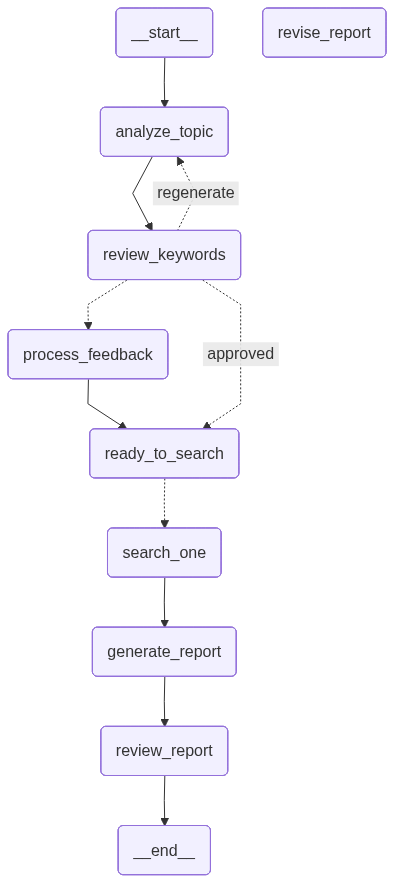

In [46]:
# ===== 워크플로우 구성 =====
# 1. ready_to_search (검색 준비)
# 2. dispatch_searches (병렬 검색 시작)
# 3. search_one (개별 검색 - 병렬)
# 4. generate_report (검색 결과 취합/리듀스) 
# 5. review_report (보고서 검토)
# 6. revise_report (보고서 수정)

workflow = StateGraph(ResearchState)

# 노드 추가
workflow.add_node("analyze_topic", generate_keywords)
workflow.add_node("review_keywords", review_keywords)
workflow.add_node("process_feedback", process_keyword_feedback)

workflow.add_node("ready_to_search", ready_to_search)
workflow.add_node("search_one", search_one)  # Send의 타겟 노드
workflow.add_node("generate_report", generate_report)

workflow.add_node("review_report", review_report)
workflow.add_node("revise_report", revise_report)

# 엣지 연결
workflow.add_edge(START, "analyze_topic")
workflow.add_edge("analyze_topic", "review_keywords")

# 키워드 검토 후 조건부 라우팅
workflow.add_conditional_edges(
    "review_keywords",
    should_continue_after_review,
    {
        "process_feedback": "process_feedback",
        "regenerate": "analyze_topic",
        "approved": "ready_to_search"
    }
)

# 피드백 처리 후 검색
workflow.add_edge("process_feedback", "ready_to_search")

# Send 맵-리듀스 연결
workflow.add_conditional_edges(
    "ready_to_search",
    dispatch_searches,
    ["search_one"]
)
workflow.add_edge("search_one", "generate_report")


# 보고서 생성 후 검토
workflow.add_edge("generate_report", "review_report")
workflow.add_edge("revise_report", "review_report")

# 컴파일
graph = workflow.compile(checkpointer=InMemorySaver())

# 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

In [47]:
# 초기 상태 설정
initial_state = {
    "topic": "LangGraph와 LlamaIndex 비교"
}
    
# 스레드 설정
config = {"configurable": {"thread_id": f"test_thread_1"}}


# 워크플로우 실행
# 첫 번째 실행 - 중단점에서 실행을 멈춤
for event in graph.stream(initial_state, config=config):
    print(f"Event: {event}")

Event: {'analyze_topic': {'keywords': ['LangGraph', 'LlamaIndex', '지식 그래프', '언어 모델 인덱싱', '데이터 통합', '자연어 처리', '정보 검색'], 'messages': [AIMessage(content='키워드 7개 생성 (신뢰도: 90%)', additional_kwargs={}, response_metadata={}, id='b92f888b-9c3b-49f7-b288-18efb502f90a')]}}
Event: {'__interrupt__': (Interrupt(value={'keywords': ['LangGraph', 'LlamaIndex', '지식 그래프', '언어 모델 인덱싱', '데이터 통합', '자연어 처리', '정보 검색'], 'question': "키워드 검토:\n1. LangGraph\n2. LlamaIndex\n3. 지식 그래프\n4. 언어 모델 인덱싱\n5. 데이터 통합\n6. 자연어 처리\n7. 정보 검색\n\n옵션:\n- '승인': 현재 키워드 사용\n- '재생성': 새 키워드 생성\n- '수정: 키워드1,키워드2,...': 직접 수정"}, id='ab8079e1244415028202d1bec706dc28'),)}


In [48]:
from langgraph.types import Command

# 사용자 피드백 제공 (승인 문자열을 사용)
human_feedback = "승인"

# 사용자 입력으로 그래프 재개
for event in graph.stream(Command(resume=human_feedback), config=config): 
    print(f"Event: {event}")

Event: {'review_keywords': {'feedback': '승인'}}
Event: {'ready_to_search': {'ready_for_search': True}}
Event: {'search_one': {'search_results': [{'keyword': 'LlamaIndex', 'data': [{'url': 'https://www.ibm.com/think/topics/llamaindex', 'title': 'What is LlamaIndex ? | IBM', 'content': 'LlamaIndex is an open source data orchestration framework for building large language model (LLM) applications. LlamaIndex is available in Python and TypeScript and leverages a combination of tools and capabilities that simplify the process of context augmentation for generative AI (gen AI) use cases through a Retrieval-Augmented (RAG) pipeline. Data agents are LLM-driven AI agents capable of performing a range of tasks on data, including both reading and writing functions.10LlamaIndex data agents are LLM-powered knowledge works that can perform the following: LlamaIndex provides tool abstractions that wrap around the existing data query engines and abstractions for functions that can be used by the tool s

In [49]:
# 상태 출력
current_state = graph.get_state(config)

current_state.values

{'messages': [AIMessage(content='키워드 7개 생성 (신뢰도: 90%)', additional_kwargs={}, response_metadata={}, id='b92f888b-9c3b-49f7-b288-18efb502f90a')],
 'topic': 'LangGraph와 LlamaIndex 비교',
 'keywords': ['LangGraph',
  'LlamaIndex',
  '지식 그래프',
  '언어 모델 인덱싱',
  '데이터 통합',
  '자연어 처리',
  '정보 검색'],
 'ready_for_search': True,
 'search_results': [{'keyword': 'LangGraph',
   'data': [{'url': 'https://www.ibm.com/think/topics/langgraph',
     'title': 'What is LangGraph? - IBM',
     'content': '*   [Overview](https://www.ibm.com/think/topics/ai-agents#7281535) *   [Overview](https://www.ibm.com/think/topics/components-of-ai-agents#498277090) *   [Learning](https://www.ibm.com/think/topics/ai-agent-learning#498277087) *   [Tutorial: LangGraph ReAct agent](https://www.ibm.com/think/tutorials/deploy-langgraph-react-agent-manage-it-support-tickets-watsonx-ai#1287801557) *   [Overview](https://www.ibm.com/think/topics/ai-agent-protocols#1509394340) *   [Tutorial: LangGraph ReAct agent](https://www.ibm.co

In [50]:
# 다음 노드 출력
current_state.next

('review_report',)

In [51]:
from langgraph.types import Command

# 사용자 피드백 제공 
human_feedback = "비교표를 만들어서 추가하세요."

# 사용자 입력으로 그래프 재개
for event in graph.stream(Command(resume=human_feedback), config=config): 
    print(f"Event: {event}")

Event: {'review_report': {'feedback': '비교표를 만들어서 추가하세요.'}}
Event: {'revise_report': {'report': '# LangGraph와 LlamaIndex 비교\n\n## 📌 요약\nLangGraph와 LlamaIndex는 각각 AI 에이전트 및 대규모 언어 모델 애플리케이션을 위한 오픈소스 프레임워크로, LangGraph는 그래프 기반 구조를 활용하여 복잡한 생성 AI 워크플로우를 구축 및 관리하는 데 중점을 두고 있고, LlamaIndex는 데이터 오케스트레이션과 검색 기반 증강을 통해 문서 중심 AI 에이전트를 개발하는 데 특화되어 있다.\n\n## 🔍 주요 발견사항\n1. LangGraph는 LangChain에서 개발된 오픈소스 AI 에이전트 프레임워크로, 그래프 기반 아키텍처를 활용하여 AI 에이전트 워크플로우 내 다양한 구성 요소 간의 복잡한 관계를 모델링하고 관리한다. (출처: IBM, https://www.ibm.com/think/topics/langgraph, GitHub https://github.com/langchain-ai/langgraph)  \n2. LangGraph는 Python 기반이며, 챗봇, 상태 그래프, 다중 에이전트 시스템 등 다양한 AI 솔루션 개발에 사용된다. (출처: LangChain 공식 https://www.langchain.com/langgraph)  \n3. LlamaIndex는 대규모 언어 모델(LLM) 애플리케이션 구축을 위한 데이터 오케스트레이션 프레임워크로, Retrieval-Augmented Generation(RAG) 파이프라인을 통해 문맥 보강을 단순화한다. (출처: IBM, https://www.ibm.com/think/topics/llamaindex)  \n4. LlamaIndex는 Python과 TypeScript에서 사용 가능하며, 문서 파싱 및 추출, 복잡한 문서에 대한 추론 및 비즈니스 로직 적응이 가능한 지능형 에이전트 구축을 지

In [52]:
# 상태 출력
current_state = graph.get_state(config)
print(current_state.values.get("report", []))

# LangGraph와 LlamaIndex 비교

## 📌 요약
LangGraph와 LlamaIndex는 각각 AI 에이전트 및 대규모 언어 모델 애플리케이션을 위한 오픈소스 프레임워크로, LangGraph는 그래프 기반 구조를 활용하여 복잡한 생성 AI 워크플로우를 구축 및 관리하는 데 중점을 두고 있고, LlamaIndex는 데이터 오케스트레이션과 검색 기반 증강을 통해 문서 중심 AI 에이전트를 개발하는 데 특화되어 있다.

## 🔍 주요 발견사항
1. LangGraph는 LangChain에서 개발된 오픈소스 AI 에이전트 프레임워크로, 그래프 기반 아키텍처를 활용하여 AI 에이전트 워크플로우 내 다양한 구성 요소 간의 복잡한 관계를 모델링하고 관리한다. (출처: IBM, https://www.ibm.com/think/topics/langgraph, GitHub https://github.com/langchain-ai/langgraph)  
2. LangGraph는 Python 기반이며, 챗봇, 상태 그래프, 다중 에이전트 시스템 등 다양한 AI 솔루션 개발에 사용된다. (출처: LangChain 공식 https://www.langchain.com/langgraph)  
3. LlamaIndex는 대규모 언어 모델(LLM) 애플리케이션 구축을 위한 데이터 오케스트레이션 프레임워크로, Retrieval-Augmented Generation(RAG) 파이프라인을 통해 문맥 보강을 단순화한다. (출처: IBM, https://www.ibm.com/think/topics/llamaindex)  
4. LlamaIndex는 Python과 TypeScript에서 사용 가능하며, 문서 파싱 및 추출, 복잡한 문서에 대한 추론 및 비즈니스 로직 적응이 가능한 지능형 에이전트 구축을 지원한다. (출처: LinkedIn https://www.linkedin.com/company/llamaindex)

## 📊 LangGraph와 LlamaIndex 비교표

| 항목    

In [53]:
from langgraph.types import Command

# 사용자 피드백 제공 (승인 문자열을 사용)
human_feedback = "승인"

# 사용자 입력으로 그래프 재개
for event in graph.stream(Command(resume=human_feedback), config=config): 
    print(f"Event: {event}")

Event: {'review_report': {'feedback': '승인'}}


In [54]:
# 마지막 상태 출력
final_state = graph.get_state(config)

# 최종 검색 결과 출력
print(final_state.values.get("report", []))

# LangGraph와 LlamaIndex 비교

## 📌 요약
LangGraph와 LlamaIndex는 각각 AI 에이전트 및 대규모 언어 모델 애플리케이션을 위한 오픈소스 프레임워크로, LangGraph는 그래프 기반 구조를 활용하여 복잡한 생성 AI 워크플로우를 구축 및 관리하는 데 중점을 두고 있고, LlamaIndex는 데이터 오케스트레이션과 검색 기반 증강을 통해 문서 중심 AI 에이전트를 개발하는 데 특화되어 있다.

## 🔍 주요 발견사항
1. LangGraph는 LangChain에서 개발된 오픈소스 AI 에이전트 프레임워크로, 그래프 기반 아키텍처를 활용하여 AI 에이전트 워크플로우 내 다양한 구성 요소 간의 복잡한 관계를 모델링하고 관리한다. (출처: IBM, https://www.ibm.com/think/topics/langgraph, GitHub https://github.com/langchain-ai/langgraph)  
2. LangGraph는 Python 기반이며, 챗봇, 상태 그래프, 다중 에이전트 시스템 등 다양한 AI 솔루션 개발에 사용된다. (출처: LangChain 공식 https://www.langchain.com/langgraph)  
3. LlamaIndex는 대규모 언어 모델(LLM) 애플리케이션 구축을 위한 데이터 오케스트레이션 프레임워크로, Retrieval-Augmented Generation(RAG) 파이프라인을 통해 문맥 보강을 단순화한다. (출처: IBM, https://www.ibm.com/think/topics/llamaindex)  
4. LlamaIndex는 Python과 TypeScript에서 사용 가능하며, 문서 파싱 및 추출, 복잡한 문서에 대한 추론 및 비즈니스 로직 적응이 가능한 지능형 에이전트 구축을 지원한다. (출처: LinkedIn https://www.linkedin.com/company/llamaindex)

## 📊 LangGraph와 LlamaIndex 비교표

| 항목    

In [55]:
# 다음 노드 출력
final_state.next

()

---

## **[실습]** 웹 검색 기반 리서치 시스템 구현 

- HITL 활용 방법을 이해하고, 
- 웹 검색 기반 리서치 시스템을 개선합니다.

In [56]:
# ===== [실습] 웹 검색 기반 리서치 시스템 개선 =====

# 이 실습에서는 앞에서 학습한 HITL 기능을 활용하여
# 웹 검색 기반 리서치 시스템을 테스트합니다.

# 실습 1: 새로운 주제로 전체 워크플로우 실행
print("=" * 60)
print("실습 1: 새로운 주제로 리서치 시스템 실행")
print("=" * 60)

# 초기 상태 설정 - 관심있는 주제로 변경 가능
initial_state = {
    "topic": "양자 컴퓨팅의 최신 동향"  # 원하는 주제로 수정하세요
}

# 스레드 설정
config = {"configurable": {"thread_id": "practice_thread_1"}}

# 워크플로우 실행 - interrupt까지 실행
print("\n[단계 1] 주제 분석 및 키워드 생성 시작...")
for event in graph.stream(initial_state, config=config):
    if "analyze_topic" in event:
        print(f"  → 키워드 생성 완료")
    if "review_keywords" in event:
        print(f"  → 키워드 검토 대기 중...")

# 현재 상태 확인
current_state = graph.get_state(config)
print(f"\n[상태 확인] 다음 노드: {current_state.next}")

# interrupt 정보 확인
if current_state.tasks:
    task = current_state.tasks[0]
    interrupt_info = task.interrupts[0].value
    print(f"\n[키워드 검토 요청]")
    print(interrupt_info.get("question", ""))
    print(f"\n생성된 키워드: {interrupt_info.get('keywords', [])}")

# 실습 2: 키워드 승인 및 검색 진행
print("\n" + "=" * 60)
print("실습 2: 키워드 승인 및 웹 검색 실행")
print("=" * 60)

from langgraph.types import Command

# 키워드 승인 (다른 옵션: "재생성" 또는 "수정: 키워드1, 키워드2")
human_feedback = "승인"
print(f"\n[사용자 피드백] {human_feedback}")

# 워크플로우 재개 - 웹 검색 및 보고서 생성
print("\n[단계 2] 웹 검색 및 보고서 생성 시작...")
for event in graph.stream(Command(resume=human_feedback), config=config):
    if "ready_to_search" in event:
        print("  → 검색 준비 완료")
    if "search_one" in event:
        print("  → 웹 검색 진행 중...")
    if "generate_report" in event:
        print("  → 보고서 생성 완료")
    if "review_report" in event:
        print("  → 보고서 검토 대기 중...")

# 보고서 검토 상태 확인
current_state = graph.get_state(config)
if current_state.tasks:
    print(f"\n[상태 확인] 다음 노드: {current_state.next}")
    task = current_state.tasks[0]
    interrupt_info = task.interrupts[0].value
    print(f"\n[보고서 검토 요청]")
    print(interrupt_info.get("instruction", ""))
    print(f"\n보고서 미리보기:")
    print(interrupt_info.get("report_preview", ""))

# 실습 3: 보고서 수정 요청 테스트
print("\n" + "=" * 60)
print("실습 3: 보고서 수정 요청")
print("=" * 60)

# 보고서 수정 요청 (예: 더 구체적인 내용 추가 요청)
report_feedback = "각 키워드별로 핵심 내용을 요약해서 추가해주세요."
print(f"\n[사용자 피드백] {report_feedback}")

# 보고서 수정 진행
print("\n[단계 3] 보고서 수정 중...")
for event in graph.stream(Command(resume=report_feedback), config=config):
    if "revise_report" in event:
        print("  → 보고서 수정 완료")
    if "review_report" in event:
        print("  → 수정된 보고서 검토 대기 중...")

# 수정된 보고서 확인
current_state = graph.get_state(config)
if current_state.tasks:
    task = current_state.tasks[0]
    interrupt_info = task.interrupts[0].value
    print(f"\n[수정된 보고서 미리보기]")
    print(interrupt_info.get("report_preview", ""))

# 실습 4: 최종 승인 및 완료
print("\n" + "=" * 60)
print("실습 4: 최종 승인 및 완료")
print("=" * 60)

# 최종 승인
final_feedback = "승인"
print(f"\n[사용자 피드백] {final_feedback}")

# 워크플로우 완료
print("\n[단계 4] 워크플로우 완료...")
for event in graph.stream(Command(resume=final_feedback), config=config):
    pass

# 최종 결과 출력
final_state = graph.get_state(config)
print(f"\n[완료] 워크플로우 상태: {final_state.next}")

print("\n" + "=" * 60)
print("최종 보고서")
print("=" * 60)
print(final_state.values.get("report", ""))

print("\n\n" + "=" * 60)
print("실습 완료!")
print("=" * 60)
print("""
💡 학습 포인트:
1. interrupt()를 활용한 동적 브레이크포인트 구현
2. Command(resume=value)를 통한 사용자 피드백 전달
3. get_state()를 통한 현재 상태 및 interrupt 정보 확인
4. 다중 HITL 지점이 있는 복잡한 워크플로우 구현

🎯 추가 실습 아이디어:
- 다른 주제로 테스트 (initial_state의 'topic' 변경)
- 키워드 재생성 또는 직접 수정 테스트
- 보고서 다양한 수정 요청 테스트
- 에러 처리 로직 추가
""")

실습 1: 새로운 주제로 리서치 시스템 실행

[단계 1] 주제 분석 및 키워드 생성 시작...
  → 키워드 생성 완료

[상태 확인] 다음 노드: ('review_keywords',)

[키워드 검토 요청]
키워드 검토:
1. 양자 컴퓨팅
2. 양자 알고리즘
3. 양자 우위
4. 양자 하드웨어
5. 퀀텀 소프트웨어
6. 양자 암호화
7. 양자 네트워크

옵션:
- '승인': 현재 키워드 사용
- '재생성': 새 키워드 생성
- '수정: 키워드1,키워드2,...': 직접 수정

생성된 키워드: ['양자 컴퓨팅', '양자 알고리즘', '양자 우위', '양자 하드웨어', '퀀텀 소프트웨어', '양자 암호화', '양자 네트워크']

실습 2: 키워드 승인 및 웹 검색 실행

[사용자 피드백] 승인

[단계 2] 웹 검색 및 보고서 생성 시작...
  → 검색 준비 완료
  → 웹 검색 진행 중...
  → 웹 검색 진행 중...
  → 웹 검색 진행 중...
  → 웹 검색 진행 중...
  → 웹 검색 진행 중...
  → 웹 검색 진행 중...
  → 웹 검색 진행 중...
  → 보고서 생성 완료

[상태 확인] 다음 노드: ('review_report',)

[보고서 검토 요청]
보고서를 검토하세요. '승인' 또는 구체적인 수정 요청을 입력하세요:

보고서 미리보기:
# 양자 컴퓨팅의 최신 동향

## 📌 요약
양자 컴퓨팅은 양자 역학의 원리를 활용하여 기존 컴퓨터로는 해결하기 어려운 문제를 빠르게 처리하는 혁신적인 기술로, 중첩과 양자 간섭 등의 현상을 이용한다. 최근 양자 컴퓨팅의 주요 동향으로는 하드웨어 기술 발전(초전도 큐비트, 이온트랩 큐비트), 양자 알고리즘 개발, 소프트웨어 플랫폼 강화, 양자 암호화 기술 및 양자 네트워크 구축이 활발히 진행되고 있다.

## 🔍 주요 발견사항
1. IBM, Amazon AWS, Microsoft 등 주요 IT 기업들이 양자 컴퓨팅의 원리와 응용 분야(기계 학습, 최적화, 물리 시스템 시뮬레이션 등)를 적극적으